In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

In [4]:
combined_df = pd.read_csv("dataset.csv")
combined_df

,Unnamed: 0,index,PLAYER,SEASON_X,SEASON_Y,PTS_x,REB_x,AST_x,STL_x,BLK_x,...,STL_pg_y,BLK_pg_y,MIN_pg_y,PTS_DIFF,REB_DIFF,AST_DIFF,STL_DIFF,BLK_DIFF,MIN_DIFF,breakout?
0,0,0,Domantas Sabonis,2022-23,2023-24,1510,973,573,65,39,...,0.902439,0.585366,35.707317,0.312905,1.342081,0.954153,0.079654,0.091695,1.074406,1
1,1,1,Scottie Barnes,2022-23,2023-24,1179,512,371,83,61,...,1.250000,1.466667,34.900000,4.538312,1.583983,1.231818,0.172078,0.674459,0.120779,1
2,2,2,Franz Wagner,2022-23,2023-24,1485,329,283,77,17,...,1.055556,0.388889,32.458333,1.173611,1.179167,0.198611,0.093056,0.176389,-0.154167,1
3,3,3,Bam Adebayo,2022-23,2023-24,1529,688,240,88,61,...,1.140845,0.929577,34.028169,-1.133146,1.206948,0.715493,-0.032488,0.116244,-0.611831,1
4,4,4,Fred VanVleet,2022-23,2023-24,1335,280,495,123,38,...,1.383562,0.808219,36.767123,-1.950566,-0.249752,0.894580,-0.399047,0.257495,0.027993,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8582,8582,6605,Ira Bowman,2000-01,2001-02,0,2,7,0,0,...,0.666667,0.000000,9.666667,3.333333,-0.333333,-2.000000,0.666667,0.000000,3.333333,0
8583,8583,6606,Zendon Hamilton,2000-01,2001-02,9,8,0,0,0,...,0.388889,0.333333,15.666667,3.000000,2.018519,0.259259,0.388889,0.333333,9.333333,0
8584,8584,6607,Jason Hart,2000-01,2001-02,2,0,1,0,0,...,0.700000,0.100000,9.300000,0.600000,1.300000,0.200000,0.700000,0.100000,-0.700000,0
8585,8585,6608,Mamadou N'diaye,2000-01,2001-02,4,2,0,0,0,...,0.000000,0.400000,9.400000,2.666667,1.533333,0.000000,0.000000,0.400000,6.066667,0


In [13]:
leakage_safe_features = [col for col in combined_df.columns if col.endswith('_pg_x') or col.endswith('_pg_y')]
leakage_safe_features = [col for col in leakage_safe_features if col not in ['PTS_pg_y', 'REB_pg_y']] # Using all Y stats might still be too descriptive
                                                                                                      # Let's use X-stats as predictors of Y-breakout

# A better, leakage-free feature set uses the PRIOR YEAR's stats (*_pg_x) 
# to predict if the player will break out in the *next* year (Y).
predictor_features = [col for col in combined_df.columns if col.endswith('_pg_x')]
predictor_features.extend([col for col in combined_df.columns if col.startswith('MIN_pg_x')]) # Include MIN_pg_x if it exists

X = combined_df[predictor_features]
y = combined_df['breakout?']

print("--------------------------------------------------")
print(f"✅ Features selected (Leakage-Free): {predictor_features}")
print("--------------------------------------------------")

# --- 3. Data Splitting ---

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 4. Data Scaling ---

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 5. Model Training (kNN) ---

k = 5 # Reduced k for small sample size
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

# --- 6. Prediction and Evaluation ---

y_pred = knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

print(f"Data split: Training samples={len(X_train)}, Testing samples={len(X_test)}")
print(f"kNN Model trained with k={k} neighbors.")
print("\n" + "="*50)
print(f"📉 Model Accuracy (k={k}) on Leakage-Free Features: {accuracy:.2f}")
print("="*50)
print("Classification Report:")
print(report)

--------------------------------------------------
✅ Features selected (Leakage-Free): ['PTS_pg_x', 'REB_pg_x', 'AST_pg_x', 'STL_pg_x', 'BLK_pg_x', 'MIN_pg_x', 'MIN_pg_x']
--------------------------------------------------
Data split: Training samples=6869, Testing samples=1718
kNN Model trained with k=5 neighbors.

📉 Model Accuracy (k=5) on Leakage-Free Features: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1322
           1       0.31      0.16      0.21       396

    accuracy                           0.72      1718
   macro avg       0.55      0.53      0.52      1718
weighted avg       0.67      0.72      0.69      1718



/Users/sethjohnson/Documents/Programming/School/CSC 466/nba_regressor/venv/lib/python3.13/site-packages/sklearn/utils/_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


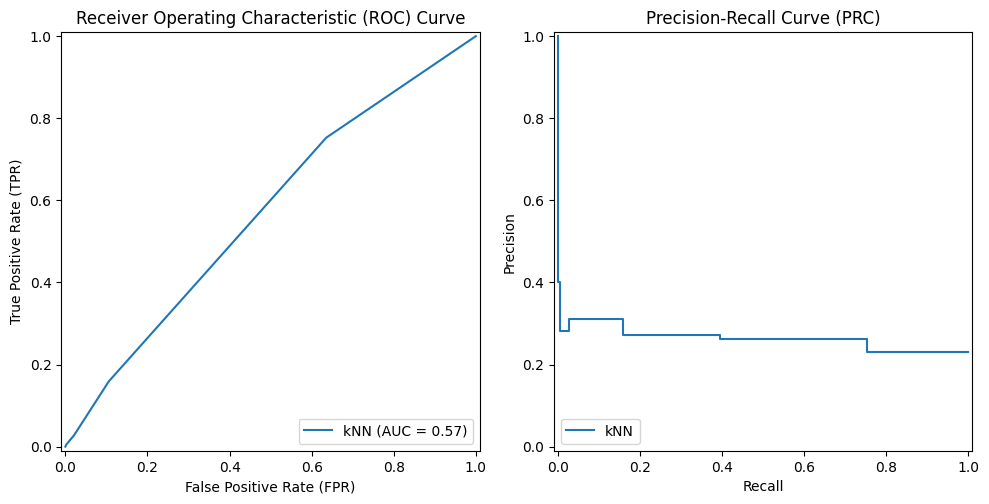

In [14]:
y_scores = knn.predict_proba(X_test_scaled)[:, 1]

# --- 6. Plotting and Evaluation ---

## 6a. Receiver Operating Characteristic (ROC) Curve

# Calculate ROC metrics: False Positive Rate (FPR), True Positive Rate (TPR), and Area Under the Curve (AUC)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='kNN').plot(ax=plt.gca())
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')

## 6b. Precision-Recall Curve (PRC)

# Calculate PRC metrics: Precision, Recall, and AUC (AUPRC)
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)

# AUC for PRC (Area Under the Precision-Recall Curve, or Average Precision)
prc_auc = auc(recall, precision) 

plt.subplot(1, 2, 2)
PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name='kNN').plot(ax=plt.gca())
plt.title('Precision-Recall Curve (PRC)')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.tight_layout()
plt.show() # Display the generated plot 


In [15]:
# Print AUC results
print("="*50)
print(f"Metrics based on kNN (k={k}) on Test Data:")
print(f"Area Under ROC Curve (AUC): {roc_auc:.4f}")
print(f"Area Under Precision-Recall Curve (AUPRC): {prc_auc:.4f}")
print("="*50)

Metrics based on kNN (k=5) on Test Data:
Area Under ROC Curve (AUC): 0.5691
Area Under Precision-Recall Curve (AUPRC): 0.2753
